## Prepare the data

### 1. Load the fine-tuning data

In [34]:
import json

file_path = "/Users/vasuhiteshi/Documents/llm/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

### 2. Load the tokenizer

In [35]:
import sys
sys.path.append('..')

In [36]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="/Users/vasuhiteshi/Documents/llm/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [37]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

134

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [38]:
initial_split_index = int(0.9 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Person 2'):
    split_index -= 1

    
    
train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 2

Validation set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 1


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [39]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [40]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [41]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 44
Length after: 22

Validation data
Length before: 7
Length after: 3


Let's convert each sequence of tokens into a tensor.

In [32]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 203 at dim 1 (got 166)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [42]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=combined_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=combined_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([22, 256]), torch.Size([3, 256]))

In [19]:
train_data_tensor[0]

tensor([1024,   80,  282,  115,  286,   32,   49, 1025,   72,  101,  121,   10,
         567,  119,   32,  288,  101,   32,  893,   63,   10,   91,   50,   54,
          47,   48,   50,   47,   50,   48,   50,   53,   44,   32,   57,   58,
          49,   56,   32,   65,   77,   93,   32,  126,   32,   80,  282,  115,
         286,   32,   50,   58,   32,   72,  101,  121,   33,   32,   73,  329,
         109,   32,  103,  320,  100,   44,   32,  119,  522,   32,  386,  295,
         116,   32,  893,   63,   10,   91,   50,   54,   47,   48,   50,   47,
          50,   48,   50,   53,   44,   32,   57,   58,   50,   48,   32,   65,
          77,   93,   32,  126,   32,   80,  282,  115,  286,   32,   49,   58,
          32,   73,  329,  109,   32,  103,  320,  100,   32,  289,  111,   44,
          32,  106,  327,  116,   32,   97,   32,   98,  336,   32,  307,  298,
         100, 1026, 1024,   80,  282,  115,  286,   32,   50, 1025,   76,  286,
         103,   32,  445,  409,  116,   

In [20]:
val_data_tensor[0]

tensor([1024,   80,  282,  115,  286,   32,   49, 1025,  407,   32,  926,  365,
         359, 1026, 1024,   80,  282,  115,  286,   32,   50, 1025,   65,  108,
         365,  409,  116,   44,   32,  627,  100,  121,   32,  289,   32,  339,
          97,  100,   32,  295,  116,   63, 1026, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 10

### 5. Creat the data loaders

In [43]:
train_data_tensor.shape

torch.Size([22, 256])

In [44]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [45]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([22, 256]), torch.Size([22, 256]))

## Fine-tuning

### 1. Load the saved checkpoint

In [58]:
from transformer.model import GPTLanguageModel
import torch

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model config
block_size = 512
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

# Model instantiation
model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

# Print param count
print(sum(p.numel() for p in model.parameters()) / 1e6, 'M parameters')

# Load checkpoint
checkpoint_path = "/Users/vasuhiteshi/Documents/llm/pre_training/checkpoint_90.pth"
checkpoint = torch.load(checkpoint_path)

model_state_dict = checkpoint["model_state_dict"]

# Load weights BEFORE compiling
model.load_state_dict(model_state_dict)

# Now compile
model = torch.compile(model)

13.92641 M parameters


RuntimeError: Error(s) in loading state_dict for GPTLanguageModel:
	Missing key(s) in state_dict: "token_embedding_table.weight", "position_embedding_table.weight", "blocks.0.self_attention.heads.0.tril", "blocks.0.self_attention.heads.0.key.weight", "blocks.0.self_attention.heads.0.query.weight", "blocks.0.self_attention.heads.0.value.weight", "blocks.0.self_attention.heads.1.tril", "blocks.0.self_attention.heads.1.key.weight", "blocks.0.self_attention.heads.1.query.weight", "blocks.0.self_attention.heads.1.value.weight", "blocks.0.self_attention.heads.2.tril", "blocks.0.self_attention.heads.2.key.weight", "blocks.0.self_attention.heads.2.query.weight", "blocks.0.self_attention.heads.2.value.weight", "blocks.0.self_attention.heads.3.tril", "blocks.0.self_attention.heads.3.key.weight", "blocks.0.self_attention.heads.3.query.weight", "blocks.0.self_attention.heads.3.value.weight", "blocks.0.self_attention.heads.4.tril", "blocks.0.self_attention.heads.4.key.weight", "blocks.0.self_attention.heads.4.query.weight", "blocks.0.self_attention.heads.4.value.weight", "blocks.0.self_attention.heads.5.tril", "blocks.0.self_attention.heads.5.key.weight", "blocks.0.self_attention.heads.5.query.weight", "blocks.0.self_attention.heads.5.value.weight", "blocks.0.self_attention.heads.6.tril", "blocks.0.self_attention.heads.6.key.weight", "blocks.0.self_attention.heads.6.query.weight", "blocks.0.self_attention.heads.6.value.weight", "blocks.0.self_attention.heads.7.tril", "blocks.0.self_attention.heads.7.key.weight", "blocks.0.self_attention.heads.7.query.weight", "blocks.0.self_attention.heads.7.value.weight", "blocks.0.self_attention.projection.weight", "blocks.0.self_attention.projection.bias", "blocks.0.feed_forward.net.0.weight", "blocks.0.feed_forward.net.0.bias", "blocks.0.feed_forward.net.2.weight", "blocks.0.feed_forward.net.2.bias", "blocks.0.layer_norm_1.weight", "blocks.0.layer_norm_1.bias", "blocks.0.layer_norm_2.weight", "blocks.0.layer_norm_2.bias", "blocks.1.self_attention.heads.0.tril", "blocks.1.self_attention.heads.0.key.weight", "blocks.1.self_attention.heads.0.query.weight", "blocks.1.self_attention.heads.0.value.weight", "blocks.1.self_attention.heads.1.tril", "blocks.1.self_attention.heads.1.key.weight", "blocks.1.self_attention.heads.1.query.weight", "blocks.1.self_attention.heads.1.value.weight", "blocks.1.self_attention.heads.2.tril", "blocks.1.self_attention.heads.2.key.weight", "blocks.1.self_attention.heads.2.query.weight", "blocks.1.self_attention.heads.2.value.weight", "blocks.1.self_attention.heads.3.tril", "blocks.1.self_attention.heads.3.key.weight", "blocks.1.self_attention.heads.3.query.weight", "blocks.1.self_attention.heads.3.value.weight", "blocks.1.self_attention.heads.4.tril", "blocks.1.self_attention.heads.4.key.weight", "blocks.1.self_attention.heads.4.query.weight", "blocks.1.self_attention.heads.4.value.weight", "blocks.1.self_attention.heads.5.tril", "blocks.1.self_attention.heads.5.key.weight", "blocks.1.self_attention.heads.5.query.weight", "blocks.1.self_attention.heads.5.value.weight", "blocks.1.self_attention.heads.6.tril", "blocks.1.self_attention.heads.6.key.weight", "blocks.1.self_attention.heads.6.query.weight", "blocks.1.self_attention.heads.6.value.weight", "blocks.1.self_attention.heads.7.tril", "blocks.1.self_attention.heads.7.key.weight", "blocks.1.self_attention.heads.7.query.weight", "blocks.1.self_attention.heads.7.value.weight", "blocks.1.self_attention.projection.weight", "blocks.1.self_attention.projection.bias", "blocks.1.feed_forward.net.0.weight", "blocks.1.feed_forward.net.0.bias", "blocks.1.feed_forward.net.2.weight", "blocks.1.feed_forward.net.2.bias", "blocks.1.layer_norm_1.weight", "blocks.1.layer_norm_1.bias", "blocks.1.layer_norm_2.weight", "blocks.1.layer_norm_2.bias", "blocks.2.self_attention.heads.0.tril", "blocks.2.self_attention.heads.0.key.weight", "blocks.2.self_attention.heads.0.query.weight", "blocks.2.self_attention.heads.0.value.weight", "blocks.2.self_attention.heads.1.tril", "blocks.2.self_attention.heads.1.key.weight", "blocks.2.self_attention.heads.1.query.weight", "blocks.2.self_attention.heads.1.value.weight", "blocks.2.self_attention.heads.2.tril", "blocks.2.self_attention.heads.2.key.weight", "blocks.2.self_attention.heads.2.query.weight", "blocks.2.self_attention.heads.2.value.weight", "blocks.2.self_attention.heads.3.tril", "blocks.2.self_attention.heads.3.key.weight", "blocks.2.self_attention.heads.3.query.weight", "blocks.2.self_attention.heads.3.value.weight", "blocks.2.self_attention.heads.4.tril", "blocks.2.self_attention.heads.4.key.weight", "blocks.2.self_attention.heads.4.query.weight", "blocks.2.self_attention.heads.4.value.weight", "blocks.2.self_attention.heads.5.tril", "blocks.2.self_attention.heads.5.key.weight", "blocks.2.self_attention.heads.5.query.weight", "blocks.2.self_attention.heads.5.value.weight", "blocks.2.self_attention.heads.6.tril", "blocks.2.self_attention.heads.6.key.weight", "blocks.2.self_attention.heads.6.query.weight", "blocks.2.self_attention.heads.6.value.weight", "blocks.2.self_attention.heads.7.tril", "blocks.2.self_attention.heads.7.key.weight", "blocks.2.self_attention.heads.7.query.weight", "blocks.2.self_attention.heads.7.value.weight", "blocks.2.self_attention.projection.weight", "blocks.2.self_attention.projection.bias", "blocks.2.feed_forward.net.0.weight", "blocks.2.feed_forward.net.0.bias", "blocks.2.feed_forward.net.2.weight", "blocks.2.feed_forward.net.2.bias", "blocks.2.layer_norm_1.weight", "blocks.2.layer_norm_1.bias", "blocks.2.layer_norm_2.weight", "blocks.2.layer_norm_2.bias", "blocks.3.self_attention.heads.0.tril", "blocks.3.self_attention.heads.0.key.weight", "blocks.3.self_attention.heads.0.query.weight", "blocks.3.self_attention.heads.0.value.weight", "blocks.3.self_attention.heads.1.tril", "blocks.3.self_attention.heads.1.key.weight", "blocks.3.self_attention.heads.1.query.weight", "blocks.3.self_attention.heads.1.value.weight", "blocks.3.self_attention.heads.2.tril", "blocks.3.self_attention.heads.2.key.weight", "blocks.3.self_attention.heads.2.query.weight", "blocks.3.self_attention.heads.2.value.weight", "blocks.3.self_attention.heads.3.tril", "blocks.3.self_attention.heads.3.key.weight", "blocks.3.self_attention.heads.3.query.weight", "blocks.3.self_attention.heads.3.value.weight", "blocks.3.self_attention.heads.4.tril", "blocks.3.self_attention.heads.4.key.weight", "blocks.3.self_attention.heads.4.query.weight", "blocks.3.self_attention.heads.4.value.weight", "blocks.3.self_attention.heads.5.tril", "blocks.3.self_attention.heads.5.key.weight", "blocks.3.self_attention.heads.5.query.weight", "blocks.3.self_attention.heads.5.value.weight", "blocks.3.self_attention.heads.6.tril", "blocks.3.self_attention.heads.6.key.weight", "blocks.3.self_attention.heads.6.query.weight", "blocks.3.self_attention.heads.6.value.weight", "blocks.3.self_attention.heads.7.tril", "blocks.3.self_attention.heads.7.key.weight", "blocks.3.self_attention.heads.7.query.weight", "blocks.3.self_attention.heads.7.value.weight", "blocks.3.self_attention.projection.weight", "blocks.3.self_attention.projection.bias", "blocks.3.feed_forward.net.0.weight", "blocks.3.feed_forward.net.0.bias", "blocks.3.feed_forward.net.2.weight", "blocks.3.feed_forward.net.2.bias", "blocks.3.layer_norm_1.weight", "blocks.3.layer_norm_1.bias", "blocks.3.layer_norm_2.weight", "blocks.3.layer_norm_2.bias", "final_layer_norm.weight", "final_layer_norm.bias", "final_linear_layer.weight", "final_linear_layer.bias". 
	Unexpected key(s) in state_dict: "_orig_mod.token_embedding_table.weight", "_orig_mod.position_embedding_table.weight", "_orig_mod.blocks.0.self_attention.heads.0.tril", "_orig_mod.blocks.0.self_attention.heads.0.key.weight", "_orig_mod.blocks.0.self_attention.heads.0.query.weight", "_orig_mod.blocks.0.self_attention.heads.0.value.weight", "_orig_mod.blocks.0.self_attention.heads.1.tril", "_orig_mod.blocks.0.self_attention.heads.1.key.weight", "_orig_mod.blocks.0.self_attention.heads.1.query.weight", "_orig_mod.blocks.0.self_attention.heads.1.value.weight", "_orig_mod.blocks.0.self_attention.heads.2.tril", "_orig_mod.blocks.0.self_attention.heads.2.key.weight", "_orig_mod.blocks.0.self_attention.heads.2.query.weight", "_orig_mod.blocks.0.self_attention.heads.2.value.weight", "_orig_mod.blocks.0.self_attention.heads.3.tril", "_orig_mod.blocks.0.self_attention.heads.3.key.weight", "_orig_mod.blocks.0.self_attention.heads.3.query.weight", "_orig_mod.blocks.0.self_attention.heads.3.value.weight", "_orig_mod.blocks.0.self_attention.heads.4.tril", "_orig_mod.blocks.0.self_attention.heads.4.key.weight", "_orig_mod.blocks.0.self_attention.heads.4.query.weight", "_orig_mod.blocks.0.self_attention.heads.4.value.weight", "_orig_mod.blocks.0.self_attention.heads.5.tril", "_orig_mod.blocks.0.self_attention.heads.5.key.weight", "_orig_mod.blocks.0.self_attention.heads.5.query.weight", "_orig_mod.blocks.0.self_attention.heads.5.value.weight", "_orig_mod.blocks.0.self_attention.heads.6.tril", "_orig_mod.blocks.0.self_attention.heads.6.key.weight", "_orig_mod.blocks.0.self_attention.heads.6.query.weight", "_orig_mod.blocks.0.self_attention.heads.6.value.weight", "_orig_mod.blocks.0.self_attention.heads.7.tril", "_orig_mod.blocks.0.self_attention.heads.7.key.weight", "_orig_mod.blocks.0.self_attention.heads.7.query.weight", "_orig_mod.blocks.0.self_attention.heads.7.value.weight", "_orig_mod.blocks.0.self_attention.projection.weight", "_orig_mod.blocks.0.self_attention.projection.bias", "_orig_mod.blocks.0.feed_forward.net.0.weight", "_orig_mod.blocks.0.feed_forward.net.0.bias", "_orig_mod.blocks.0.feed_forward.net.2.weight", "_orig_mod.blocks.0.feed_forward.net.2.bias", "_orig_mod.blocks.0.layer_norm_1.weight", "_orig_mod.blocks.0.layer_norm_1.bias", "_orig_mod.blocks.0.layer_norm_2.weight", "_orig_mod.blocks.0.layer_norm_2.bias", "_orig_mod.final_layer_norm.weight", "_orig_mod.final_layer_norm.bias", "_orig_mod.final_linear_layer.weight", "_orig_mod.final_linear_layer.bias". 

In [60]:
import torch
from transformer.model import GPTLanguageModel

# --- Tokenizer setup (Assuming you already have it) ---
# tokenizer = ...
# vocab_size = get_vocab_size(tokenizer)

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Set model hyperparameters ---
block_size = 512  # Must match what was used to train the checkpoint
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

# --- Initialize the model (before compilation or checkpoint loading) ---
model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters.")

# --- Load checkpoint ---
checkpoint_path = "/Users/vasuhiteshi/Documents/llm/pre_training/checkpoint_90.pth"
checkpoint = torch.load(checkpoint_path)

# --- Clean state_dict by removing _orig_mod. prefix ---
model_state_dict = checkpoint["model_state_dict"]
cleaned_state_dict = {
    k.replace("_orig_mod.", ""): v for k, v in model_state_dict.items()
}

# --- Load weights into model ---
missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)

# Optional debug
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

# --- Compile model (for inference or training speedup) ---
model = torch.compile(model)

Model has 13.93M parameters.
Missing keys: ['blocks.1.self_attention.heads.0.tril', 'blocks.1.self_attention.heads.0.key.weight', 'blocks.1.self_attention.heads.0.query.weight', 'blocks.1.self_attention.heads.0.value.weight', 'blocks.1.self_attention.heads.1.tril', 'blocks.1.self_attention.heads.1.key.weight', 'blocks.1.self_attention.heads.1.query.weight', 'blocks.1.self_attention.heads.1.value.weight', 'blocks.1.self_attention.heads.2.tril', 'blocks.1.self_attention.heads.2.key.weight', 'blocks.1.self_attention.heads.2.query.weight', 'blocks.1.self_attention.heads.2.value.weight', 'blocks.1.self_attention.heads.3.tril', 'blocks.1.self_attention.heads.3.key.weight', 'blocks.1.self_attention.heads.3.query.weight', 'blocks.1.self_attention.heads.3.value.weight', 'blocks.1.self_attention.heads.4.tril', 'blocks.1.self_attention.heads.4.key.weight', 'blocks.1.self_attention.heads.4.query.weight', 'blocks.1.self_attention.heads.4.value.weight', 'blocks.1.self_attention.heads.5.tril', 'block

In [54]:
checkpoint_path = "/Users/vasuhiteshi/Documents/llm/pre_training/checkpoint_90.pth"
checkpoint = torch.load(checkpoint_path)
#model.load_state_dict(model_state_dict)
model_state_dict = checkpoint["model_state_dict"]
model.load_state_dict(model_state_dict)
#model.load_state_dict(torch.load("epoch_5.pth"))

AttributeError: 'function' object has no attribute 'load_state_dict'

Generate from the model to make sure that the weights were loaded correctly.

In [62]:
input_tokens = tokenizer.encode("hello ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

hello somevec�was rnhi krr Dething hen it Kuch bhejAnsaadizri Hoclass oparbe ways ts �thombDekh kale ghHm? Bminter�on’t ve Ohh vo Suhue Fimpacour E%hai? #se baat laum�est ciil <duke kk aur btself chal kr H)loone sare � UAbhi hai �da Kore ko arrhaiya ho k😭x Abhi f ro


### 2. Estimate loss

In [63]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 3. Save checkpoints

In [65]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "/Users/vasuhiteshi/Documents/llm/fine_tuning"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [66]:
max_iters = 20
eval_interval = 20
learning_rate = 6e-5

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"/Users/vasuhiteshi/Documents/llm/fine_tuning/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 6.5393, val loss 6.6433
iteration 1 / step 0: train loss 5.3630, val loss 5.6102
iteration 2 / step 0: train loss 5.0716, val loss 5.4033
iteration 3 / step 0: train loss 5.1554, val loss 5.4770
iteration 4 / step 0: train loss 4.8268, val loss 5.1170
iteration 5 / step 0: train loss 4.5377, val loss 4.8026
iteration 6 / step 0: train loss 4.4281, val loss 4.6708
iteration 7 / step 0: train loss 4.3582, val loss 4.5784
iteration 8 / step 0: train loss 4.2616, val loss 4.4614
iteration 9 / step 0: train loss 4.1436, val loss 4.3271
iteration 10 / step 0: train loss 4.0332, val loss 4.2061
iteration 11 / step 0: train loss 3.9532, val loss 4.1231
iteration 12 / step 0: train loss 3.8970, val loss 4.0687
iteration 13 / step 0: train loss 3.8312, val loss 4.0028
iteration 14 / step 0: train loss 3.7375, val loss 3.9032
iteration 15 / step 0: train loss 3.6284, val loss 3.7830
iteration 16 / step 0: train loss 3.5270, val loss 3.6681
iteration 17 / step 0: t

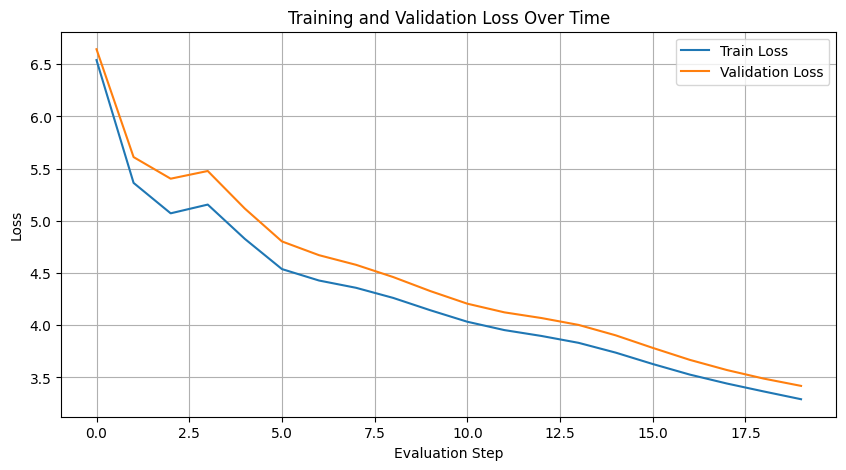

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [70]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "hello"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

try:
    model_answer += tokenizer.decode([last_generated_token])
except ValueError as e:
    print("Warning:", e)
    model_answer += "<UNK>"

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        input_tokens = input_tokens[:, -block_size:]

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: hello
Assistant: <UNK>toh Person Icom skerdi Itly un Persliye terson terson Mon you itrha hu in b Ich a har son�nhi hai �👍 2/will p,bb 
Madpla Pere�<|separator|>it ke maon Fir cha deo �0aam ya  mi!sa  bhi itf hiing t️ lg} reaacson s️ ree K️ k las? ast Persingst 2arr Pl cotheDo kr�oum rannha?pu th it 1ty ] m>)/32!mi[kon is gerson pro bylife But sel P shitoteun in takany�ood nisi book but 2002️ the derd Kya apis lasske baad rhe ke son nhi a Y We 1ops whir n..on mein Noic�Wsa studal er🥹 idhr ko esohoeen erchon vdab yedle Person cow+for son thurech yeh er waone metive th�’m&�Bol che mailc hai N�e� nhi hai outhookAchha Pnorre  ree int eek hai 10eek pen valeescidne Ax me gere Acha I krbi c null HoKa Ison 21000 ch ss n kon sonerde is fes
2�10geisi 2hun 
1, '<|separator|>But as watap�;
dsoAchcy son Mess ound Ian t😭� rhi abhi 1about 😅 we haerobson Pe<|separator|>reaT! Terb �2� B 1: bhi sot? 1<|separator|>toh gerprojminchus2son4<|separator|>lv vkiya lchaidi said I min someere isa a wday 